<a href="https://colab.research.google.com/github/datneuro/datneuro.github.io/blob/main/PPMI_Blood_ALL_BLvisit_24Dec07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT
IMPORT DATA IMPORTED WITH TXI LOCALLY ALREADY

As in 241207_Code.R to import sf files and some first processing. Briefly, choose only baseline samples (from meta data), and exist/ pass QC (393PD + 189HC --> 582)
Check carefully and mapped the sample names corretly.




In [ ]:
library(tidyverse)
library(googledrive)

#drive_auth()

In [ ]:
#drive_download(as_id("13MeP3lcyQxulePtooCU1cpZgmay1xHiB"), path = "Txi_script.RData", overwrite = TRUE)
# Load the .RData file
load("Txi_script.RData")

Warning message in readChar(con, 5L, useBytes = TRUE):
"cannot open compressed file 'Txi_script.RData', probable reason 'No such file or directory'"


ERROR: Error in readChar(con, 5L, useBytes = TRUE): cannot open the connection


In [ ]:
# https://drive.google.com/file/d/12OnCLxuc0rAMr_d6EtMLNp2oWzBo_me8/view?usp=sharing

In [ ]:
drive_download(as_id("12OnCLxuc0rAMr_d6EtMLNp2oWzBo_me8"), path = "Txi_script_24DEC7.rds", overwrite = TRUE)
# Load the .RData file
Txi_script <- readRDS("Txi_script_24DEC7.rds")


In [ ]:
myTPM <- Txi_script$abundance
myCounts <- Txi_script$counts

In [ ]:
library(tidyverse)
drive_download(as_id("12DfosyDt5oyfBPXU9Yzv9haOJRwSOowq"), path = "metaDataIR3.csv", overwrite = TRUE)
sam.BL.fil <- read_csv("metaDataIR3.csv") %>%
  dplyr::filter(DIAGNOSIS %in% c("PD", "Control"), CLINICAL_EVENT == "BL", QCflagIR3 == "pass")

In [ ]:
dim(sam.BL.fil)

In [ ]:
# capture sample labels from the filtered_samples data
sampleLabels <- sam.BL.fil$PATNO
sampleLabels <- as.character(sampleLabels)

In [ ]:
version

In [ ]:
install.packages("tidyr")
install.packages("BiocManager")
BiocManager::install("edgeR")

In [ ]:
library(edgeR)
dge <- DGEList(myCounts)

In [ ]:
head(dge)

In [ ]:
log2.cpm <- cpm(dge, log = TRUE)
log2.cpm.df <- as_tibble(log2.cpm, rownames = "geneID")

In [ ]:
log2.cpm

# FILTER AND NORMAIZATION


Import clinical data and extract age to make model later


In [ ]:
drive_download(as_id("1H4S8r4VcJ-GpBzxDip7ME5EdZW2ggDvS"), path = "PAR.UPDRS2.BL.RData", overwrite = TRUE)
# Load the .RData file
load("PAR.UPDRS2.BL.RData")

File downloaded:

• PAR.UPDRS2.BL.RData <id: 1H4S8r4VcJ-GpBzxDip7ME5EdZW2ggDvS>

Saved locally as:

• PAR.UPDRS2.BL.RData



In [ ]:
agedf <- dplyr::select( PAR.UPDRS2.BL, PATNO, ENROLL_AGE)

In [ ]:
dim(sam.BL.fil)

[1] 582  72

In [ ]:
sam.BL.fil2 <- sam.BL.fil %>%
  left_join(agedf, by = "PATNO")

In [ ]:
dim(sam.BL.fil2)

[1] 582  73

In [ ]:
if (any(is.na(sam.BL.fil2$ENROLL_AGE))) {
  sam.BL.fil2$ENROLL_AGE[is.na(sam.BL.fil2$ENROLL_AGE)] <- median(sam.BL.fil2$ENROLL_AGE, na.rm = TRUE)
}
dim(sam.BL.fil2)

[1] 582  73

In [ ]:
#sam.BL.fil2 <- merge(sam.BL.fil,agedf, by="PATNO", all.x  = T)
#dim(sam.BL.fil2)
#khong duoc chay

[1] 582  73

In [ ]:
sum(sam.BL.fil$DIAGNOSIS == sam.BL.fil2$DIAGNOSIS)

[1] 582

In [ ]:
head(sam.BL.fil$DIAGNOSIS, n= 10)
head(sam.BL.fil2$DIAGNOSIS, n= 10)


[1] "Control" "PD"      "PD"      "PD"      "PD"      "Control" "PD"     
 [8] "PD"      "PD"      "PD"

[1] "Control" "PD"      "PD"      "PD"      "PD"      "Control" "PD"     
 [8] "PD"      "PD"      "PD"

In [ ]:
any(is.na(sam.BL.fil2$ENROLL_AGE))

[1] FALSE

In [ ]:
#sam.BL.fil2$PATNO[is.na(sam.BL.fil2$ENROLL_AGE)]
sam.BL.fil2$ENROLL_AGE[is.na(sam.BL.fil2$ENROLL_AGE)] <- mean(sam.BL.fil2$ENROLL_AGE, na.rm = TRUE)
#this change other var also

In [ ]:
keepTheseGenes1 <- rowSums(log2.cpm>1)>= 400
keepTheseGenes2 <- rowSums(log2.cpm>1)>= 189
keepTheseGenes3 <- (rowSums(cpm(dge) > 1) >= 10)

In [ ]:
groups2 <- factor(sam.BL.fil2$DIAGNOSIS)
keepTheseGenes4 <-filterByExpr(dge, group = groups2)

In [ ]:
install.packages("reshape2")

Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)

also installing the dependency 'plyr'




In [ ]:
library("dplyr")
library ("reshape2")
library ("ggplot2")
library ("edgeR")

beforeFiltering_plot <- dge %>%
  cpm(log = TRUE) %>%
  melt %>%
  dplyr::filter(is.finite(value)) %>%
   mutate(Var2 = as.factor(Var2)) %>%
  ggplot(aes(x = value, colour = Var2,group = Var2)) +
  geom_density() +
  guides(colour = FALSE) +
  ggtitle("A. Before filtering", subtitle = paste0(nrow(dge), " genes")) +
  labs(x = "logCPM", y = "Density")

In [ ]:
afterFiltering_plot1 <- dge %>%
  cpm(log = TRUE) %>%
  magrittr::extract(keepTheseGenes1,) %>%
  melt %>%
  dplyr::filter(is.finite(value)) %>%
   mutate(Var2 = as.factor(Var2)) %>%
  ggplot(aes(x = value, colour = Var2,group = Var2)) +
  geom_density() +
  guides(colour = FALSE) +
  ggtitle("B. After filtering using log2cpm", subtitle = paste0(table(keepTheseGenes1)[[2]], " genes"))+
  labs(x = "logCPM", y = "Density")


In [ ]:
afterFiltering_plot2 <- dge %>%
  cpm(log = TRUE) %>%
  magrittr::extract(keepTheseGenes2,) %>%
  melt %>%
  dplyr::filter(is.finite(value)) %>%
  ggplot(aes(x = value, colour = Var2)) +
  geom_density() +
  guides(colour = FALSE) +
  ggtitle("C. After filtering 2nd criteria", subtitle = paste0(table(keepTheseGenes2)[[2]], " genes"))+
  labs(x = "logCPM", y = "Density")

In [ ]:
afterFiltering_plot3 <- dge %>%
  cpm(log = TRUE) %>%
  magrittr::extract(keepTheseGenes3,) %>%
  melt %>%
  dplyr::filter(is.finite(value)) %>%
  ggplot(aes(x = value, colour = Var2)) +
  geom_density() +
  guides(colour = FALSE) +
  ggtitle("D. After filtering 3rd criteria", subtitle = paste0(table(keepTheseGenes3)[[2]], " genes"))+
  labs(x = "logCPM", y = "Density")

In [ ]:
afterFiltering_plot4 <- dge %>%
  cpm(log = TRUE) %>%
  magrittr::extract(keepTheseGenes4,) %>%
  melt %>%
  dplyr::filter(is.finite(value)) %>%
   mutate(Var2 = as.factor(Var2)) %>%
  ggplot(aes(x = value, colour = Var2)) +
  geom_density() +
  guides(colour = FALSE) +
  ggtitle("C. After filtering filterByExpr", subtitle = paste0(table(keepTheseGenes4)[[2]], " genes"))+
  labs(x = "logCPM", y = "Density")

In [ ]:
install.packages("cowplot")

Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)



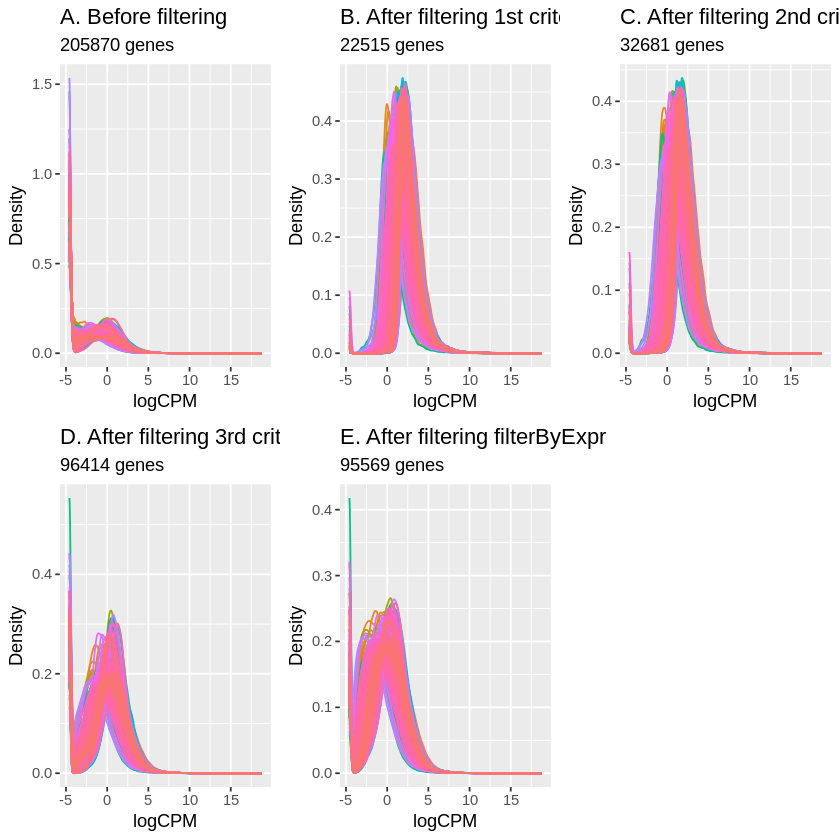

In [ ]:
cowplot::plot_grid(beforeFiltering_plot, afterFiltering_plot1, afterFiltering_plot2, afterFiltering_plot3,afterFiltering_plot4)

In [ ]:
# Save the figure to a PDF file
pdf("Filter_plot.pdf")  # Adjust width and height as needed
cowplot::plot_grid(beforeFiltering_plot, afterFiltering_plot1,afterFiltering_plot4)
dev.off()

# Upload the file to your Google Drive
drive_upload("Filter_plot.pdf")  # Change the filename as needed

pdf 
  2

Local file:

• Filter_plot.pdf

Uploaded into Drive file:

• Filter_plot.pdf <id: 1PpGGvmM6ZGYscihTD4PlxC8-9Qd-im9b>

With MIME type:

• application/pdf



In [ ]:
# Choose criteria of filter with the gene appear in at leat 189 samples (smallest group HC)
dge.filtered <- dge[keepTheseGenes4,]
dim(dge.filtered)

[1] 95569   582

In [ ]:
# Normalize your data ----
dge.filtered.norm <- calcNormFactors(dge.filtered, method = "TMM")


In [ ]:
log2.cpm.filtered.norm <- cpm(dge.filtered.norm, log = TRUE)
log2.cpm.filtered.norm.df <- as_tibble(log2.cpm.filtered.norm, rownames = "geneID")
#colnames(log2.cpm.filtered.norm.df) <- c("geneID", sampleLabels)

In [ ]:
head(log2.cpm.filtered.norm.df)

geneID,3201,4117,3471,3435,3173,3479,4110,3174,3454,⋯,3788,3807,3809,3854,3863,3867,3868,3904,3102,3418
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENST00000456328.2,-1.75536331,-2.7277863,-2.31776929,-0.7053399,-1.71852494,-0.4171748,-1.3796648,-1.7105432,-1.453366886,⋯,-0.3268079,-0.8171638,-1.285989878,-1.3866720,-0.70694002,-0.4731773,-0.5062164,-0.3974117,-1.966552105,-0.2692299
ENST00000488147.1,-1.22636564,-1.4023670,-0.73189890,-1.2013187,-1.04222314,-0.6257597,-0.8969784,-0.7433572,-0.703487205,⋯,-0.5677291,-0.9046285,-0.861894347,-1.3708850,0.07040206,-1.0337487,-0.8989597,-0.2989409,0.192462385,-0.4035860
ENST00000461467.1,2.02724750,2.4814812,2.41195200,1.9682301,1.40271789,0.7656834,2.2129789,1.7014641,1.505714077,⋯,1.5495862,1.4202519,1.844043308,1.8992600,1.69696703,1.5806608,0.7536989,0.3471835,1.504275266,1.1216413
ENST00000466430.5,-0.06661282,-0.3500703,-0.05342682,0.1538780,-0.03217241,-0.4913824,0.1884468,-0.0269818,0.007172341,⋯,0.3183738,-0.1273917,-0.003902386,0.3379028,0.45692494,0.3561020,-0.5391353,-0.6151312,0.090361070,0.3835922
ENST00000471248.1,0.77904482,1.6042775,1.13827649,0.9592382,0.79088834,0.7018447,1.5885237,1.8710509,1.248509715,⋯,1.3783315,0.7246598,0.160560384,1.4434459,1.74842841,0.8997966,1.2869529,0.1757427,0.870843282,0.7417831
ENST00000610542.1,-1.54909781,-3.6955609,-1.87797488,-1.2146516,-2.41707876,-3.2403707,-4.6274645,-1.4736522,-2.720287533,⋯,-1.3566992,-2.2834585,0.097031224,-1.6226160,1.33990659,-0.7946678,-1.9572944,-3.0319882,0.002214629,-1.1328982


In [ ]:
log2.cpm.filtered.norm.df.pivot <- pivot_longer(log2.cpm.filtered.norm.df,
                                                cols = '3201':last_col(),,
                                                names_to = "samples",
                                                values_to = "expression")

In [ ]:
head(log2.cpm.filtered.norm.df.pivot)

geneID,samples,expression
<chr>,<chr>,<dbl>
ENST00000456328.2,3201,-1.7553633
ENST00000456328.2,4117,-2.7277863
ENST00000456328.2,3471,-2.3177693
ENST00000456328.2,3435,-0.7053399
ENST00000456328.2,3173,-1.7185249
ENST00000456328.2,3479,-0.4171748


# ANNOTATION

In [ ]:
BiocManager::install("ensembldb")
#BiocManager::install("EnsDb.Hsapiens.v86")
BiocManager::install("biomaRt")
BiocManager::install("EnsDb.Hsapiens.v86")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31)

Installing package(s) 'ensembldb'

also installing the dependencies ‘matrixStats’, ‘abind’, ‘SparseArray’, ‘formatR’, ‘MatrixGenerics’, ‘S4Arrays’, ‘DelayedArray’, ‘lambda.r’, ‘futile.options’, ‘png’, ‘SummarizedExperiment’, ‘RCurl’, ‘rjson’, ‘futile.logger’, ‘snow’, ‘BH’, ‘XVector’, ‘lazyeval’, ‘plogr’, ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘KEGGREST’, ‘XML’, ‘zlibbioc’, ‘GenomicAlignments’, ‘BiocIO’, ‘restfulr’, ‘bitops’, ‘BiocParallel’, ‘Rhtslib’, ‘BiocGenerics’, ‘GenomicRanges’, ‘GenomicFeatures’, ‘AnnotationFilter’, ‘RSQLite’, ‘Biobase’, ‘GenomeInfoDb’, ‘AnnotationDbi’, ‘rtracklayer’, ‘S4Vectors’, ‘Rsamtools’, ‘IRanges’, ‘ProtGenerics’, ‘Biostrings’


Old packages: 'cpp11', 'data.table', 'textshaping'



In [ ]:
library(ensembldb)
library(EnsDb.Hsapiens.v86)
library(biomaRt)

In [ ]:
# ANNOTATION ----
ensembl <- useEnsembl(biomart = "ensembl", dataset = "hsapiens_gene_ensembl",mirror = "asia")

# Clean the transcript IDs to remove version information
transcript_ids <- log2.cpm.filtered.norm.df$geneID
clean_transcript_ids <- gsub("\\..*", "", transcript_ids)  # Remove the version number

# Retrieve gene symbols for all transcript IDs in one go
gene_info <- getBM(
  filters = "ensembl_transcript_id",
  attributes = c("ensembl_transcript_id", "external_gene_name"),
  values = clean_transcript_ids,
  mart = ensembl
)

# Merge gene_info with the log2.cpm.filtered.norm.df dataframe
NAME.log2.cpm.filtered.norm.df <- log2.cpm.filtered.norm.df %>%
  mutate(ensembl_transcript_id = clean_transcript_ids) %>%
  left_join(gene_info, by = "ensembl_transcript_id")

# Rearrange the dataframe to have gene symbols as the first column if external_gene_name exists
if ("external_gene_name" %in% colnames(NAME.log2.cpm.filtered.norm.df)) {
  NAME.log2.cpm.filtered.norm.df <- NAME.log2.cpm.filtered.norm.df %>%
    dplyr::select(external_gene_name, everything())
}



In [ ]:

# Create variables containing Specimen Bar Code for HC and PD samples
hc_id <- sam.BL.fil %>% dplyr::filter(DIAGNOSIS == "Control") %>% pull('PATNO')
pd_id <- sam.BL.fil %>% dplyr::filter(DIAGNOSIS == "PD") %>% pull('PATNO')

# Match these Specimen Bar Codes to the corresponding column names in NAME.log2.cpm.filtered.norm.df
hc_columns <- colnames(NAME.log2.cpm.filtered.norm.df)[colnames(NAME.log2.cpm.filtered.norm.df) %in% hc_id]
pd_columns <- colnames(NAME.log2.cpm.filtered.norm.df)[colnames(NAME.log2.cpm.filtered.norm.df) %in% pd_id]

In [ ]:
head(NAME.log2.cpm.filtered.norm.df
)

external_gene_name,geneID,3201,4117,3471,3435,3173,3479,4110,3174,⋯,3807,3809,3854,3863,3867,3868,3904,3102,3418,ensembl_transcript_id
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
DDX11L16,ENST00000456328.2,-1.75536331,-2.7277863,-2.31776929,-0.7053399,-1.71852494,-0.4171748,-1.3796648,-1.7105432,⋯,-0.8171638,-1.285989878,-1.3866720,-0.70694002,-0.4731773,-0.5062164,-0.3974117,-1.966552105,-0.2692299,ENST00000456328
WASH7P,ENST00000488147.1,-1.22636564,-1.4023670,-0.73189890,-1.2013187,-1.04222314,-0.6257597,-0.8969784,-0.7433572,⋯,-0.9046285,-0.861894347,-1.3708850,0.07040206,-1.0337487,-0.8989597,-0.2989409,0.192462385,-0.4035860,ENST00000488147
FAM138A,ENST00000461467.1,2.02724750,2.4814812,2.41195200,1.9682301,1.40271789,0.7656834,2.2129789,1.7014641,⋯,1.4202519,1.844043308,1.8992600,1.69696703,1.5806608,0.7536989,0.3471835,1.504275266,1.1216413,ENST00000461467
,ENST00000466430.5,-0.06661282,-0.3500703,-0.05342682,0.1538780,-0.03217241,-0.4913824,0.1884468,-0.0269818,⋯,-0.1273917,-0.003902386,0.3379028,0.45692494,0.3561020,-0.5391353,-0.6151312,0.090361070,0.3835922,ENST00000466430
,ENST00000471248.1,0.77904482,1.6042775,1.13827649,0.9592382,0.79088834,0.7018447,1.5885237,1.8710509,⋯,0.7246598,0.160560384,1.4434459,1.74842841,0.8997966,1.2869529,0.1757427,0.870843282,0.7417831,ENST00000471248
NA,ENST00000610542.1,-1.54909781,-3.6955609,-1.87797488,-1.2146516,-2.41707876,-3.2403707,-4.6274645,-1.4736522,⋯,-2.2834585,0.097031224,-1.6226160,1.33990659,-0.7946678,-1.9572944,-3.0319882,0.002214629,-1.1328982,ENST00000610542


In [ ]:
# Calculate the averages and log fold change using mutate
mydata.df <- NAME.log2.cpm.filtered.norm.df %>%
  mutate(
    healthy.AVG = rowMeans(dplyr::select(., all_of(hc_columns)), na.rm = TRUE),
    disease.AVG = rowMeans(dplyr::select(., all_of(pd_columns)), na.rm = TRUE),
    LogFC = disease.AVG - healthy.AVG
  ) %>%
  mutate_if(is.numeric, round, 2)

In [ ]:
head(mydata.df)

external_gene_name,geneID,3201,4117,3471,3435,3173,3479,4110,3174,⋯,3863,3867,3868,3904,3102,3418,ensembl_transcript_id,healthy.AVG,disease.AVG,LogFC
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
DDX11L16,ENST00000456328.2,-1.76,-2.73,-2.32,-0.71,-1.72,-0.42,-1.38,-1.71,⋯,-0.71,-0.47,-0.51,-0.40,-1.97,-0.27,ENST00000456328,-1.04,-1.03,0.01
WASH7P,ENST00000488147.1,-1.23,-1.40,-0.73,-1.20,-1.04,-0.63,-0.90,-0.74,⋯,0.07,-1.03,-0.90,-0.30,0.19,-0.40,ENST00000488147,-0.92,-0.95,-0.04
FAM138A,ENST00000461467.1,2.03,2.48,2.41,1.97,1.40,0.77,2.21,1.70,⋯,1.70,1.58,0.75,0.35,1.50,1.12,ENST00000461467,0.95,0.99,0.04
,ENST00000466430.5,-0.07,-0.35,-0.05,0.15,-0.03,-0.49,0.19,-0.03,⋯,0.46,0.36,-0.54,-0.62,0.09,0.38,ENST00000466430,-0.07,0.01,0.08
,ENST00000471248.1,0.78,1.60,1.14,0.96,0.79,0.70,1.59,1.87,⋯,1.75,0.90,1.29,0.18,0.87,0.74,ENST00000471248,0.78,0.88,0.10
NA,ENST00000610542.1,-1.55,-3.70,-1.88,-1.21,-2.42,-3.24,-4.63,-1.47,⋯,1.34,-0.79,-1.96,-3.03,0.00,-1.13,ENST00000610542,-1.61,-1.44,0.18


# VOLCANO

In [ ]:
sam.BL.fil2 <- transform(sam.BL.fil2,
                         ENROLL_AGE = scale(ENROLL_AGE),
                         `RIN Value` = scale(`RIN Value`))

In [ ]:
# Create the design matrix (ensure all column names are valid)
design <- model.matrix(~ 0 + DIAGNOSIS + ENROLL_AGE + Sex + Plate + `RIN Value`,
                       data = transform(sam.BL.fil2,
                                        DIAGNOSIS = factor(DIAGNOSIS),
                                        Sex = factor(GENDER),
                                        Plate = factor(Plate)))



In [ ]:
design <- model.matrix(~ 0 + DIAGNOSIS +`RIN Value`,
                       data = transform(sam.BL.fil2,
                                        DIAGNOSIS = factor(DIAGNOSIS)))

In [ ]:
design <- model.matrix(~ 0 + DIAGNOSIS,
                       data = transform(sam.BL.fil2,
                                        DIAGNOSIS = factor(DIAGNOSIS)))

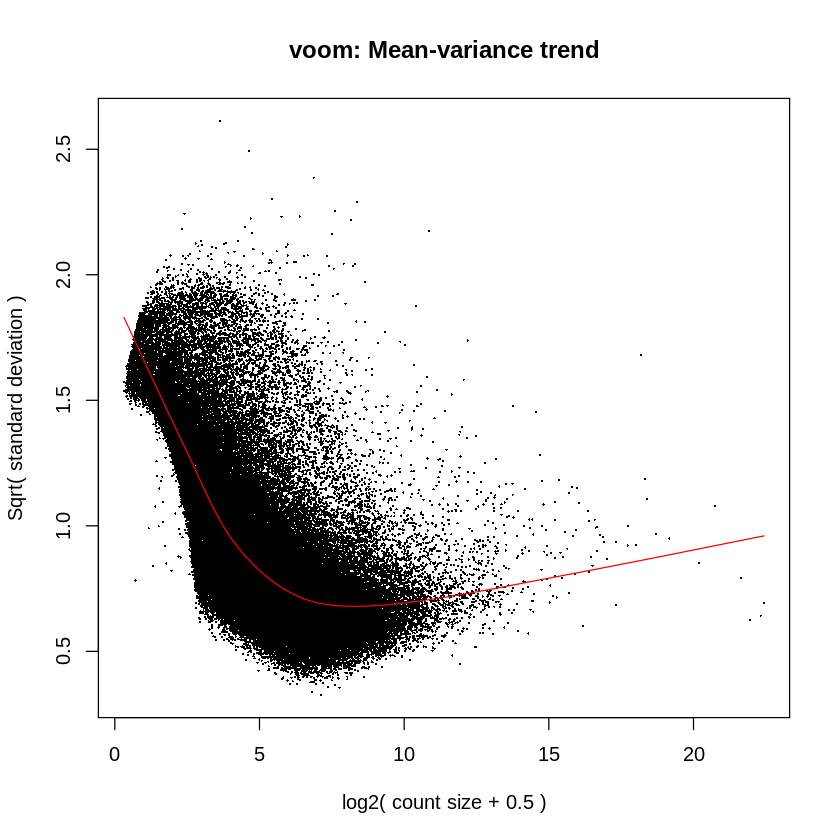

In [ ]:
# Clean up column names in the design matrix
colnames(design) <- make.names(colnames(design))

# Fit the linear model to the voom-transformed data
v.DEGLIST.filtered.norm <- voom(dge.filtered.norm, design, plot = TRUE)
# Use voomWithQualityWeights to account for sample quality differences

fit <- lmFit(v.DEGLIST.filtered.norm, design)

# Create the contrast matrix
contrast.matrix <- makeContrasts(PD_vs_Control = DIAGNOSISPD - DIAGNOSISControl, levels = design)

# Extract the linear model fit and apply Bayesian statistics
fits <- contrasts.fit(fit, contrast.matrix)
ebFit <- eBayes(fits)

# Write results to a file (optional)
# write.fit(ebFit, file = "lmfit_results.txt")

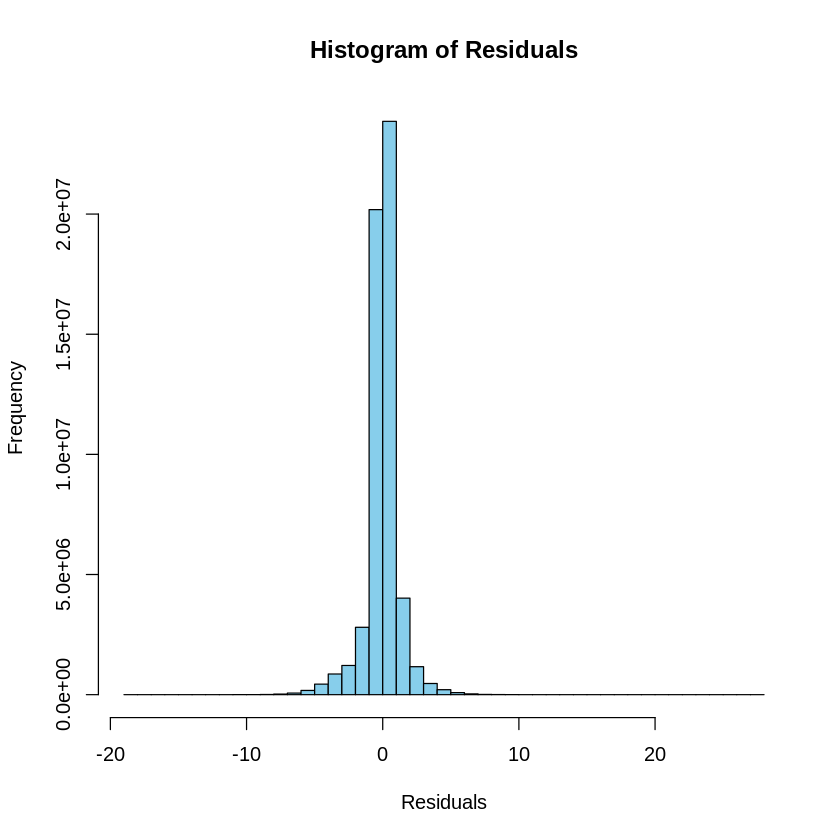

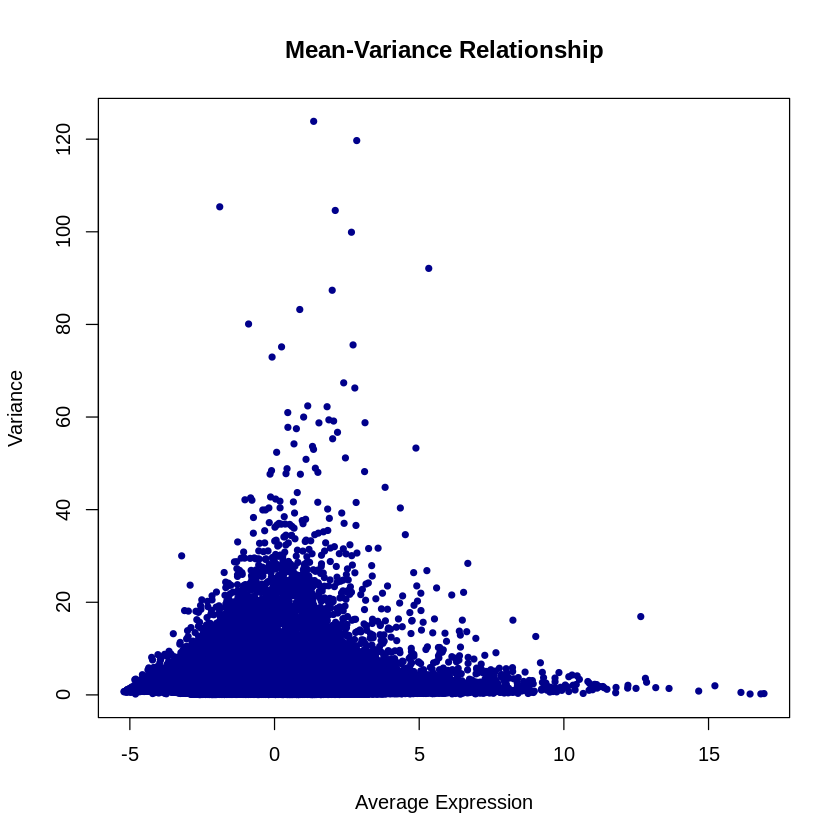

In [ ]:

residuals_data <- residuals(fit, y = v.DEGLIST.filtered.norm$E)
hist(residuals_data, main = "Histogram of Residuals", xlab = "Residuals", col = "skyblue", breaks = 50)
plot(fit$Amean, fit$sigma^2, xlab = "Average Expression", ylab = "Variance",
     main = "Mean-Variance Relationship", col = "darkblue", pch = 20)


In [ ]:
save(v.DEGLIST.filtered.norm ,file= "v.DEGLIST.filtered.norm.RData")
drive_upload("v.DEGLIST.filtered.norm.RData")

Local file:

• v.DEGLIST.filtered.norm.RData

Uploaded into Drive file:

• v.DEGLIST.filtered.norm.RData <id: 1lrX-rAKCNeid4vHobANLOftCIVUd1Fv8>

With MIME type:

• application/x-gzip



In [ ]:
pdf("residual.Dec07.pdf")  # Adjust width and height as needed
residuals_data <- residuals(fit, y = v.DEGLIST.filtered.norm$E)
hist(residuals_data, main = "Histogram of Residuals", xlab = "Residuals", col = "skyblue", breaks = 50)
plot(fit$Amean, fit$sigma^2, xlab = "Average Expression", ylab = "Variance",
     main = "Mean-Variance Relationship", col = "darkblue", pch = 20)
dev.off()
library(googledrive)
drive_upload("residual.Dec07.pdf")

pdf 
  2

Auto-refreshing stale OAuth token.

Local file:

• residual.Dec07.pdf

Uploaded into Drive file:

• residual.Dec07.pdf <id: 1-nN7p8J3KS9zgjkpPA7f2u9spPThotEI>

With MIME type:

• application/pdf



In [ ]:
#FORMATION OF UPS GENE TABLE ----
ups1 <- data.frame('Ubiquitin' = as.character(c("RPS27A", "UBA52", "UBB", "UBC",rep(NA,500-4))),
                   'Ubiquitin activating enzymes E1' =as.character(c("UBA1", "UBA6",rep(NA,500-2))),
                   'Ubiquitin conjugating enzymes E2' = as.character(c("UBE2A", "UBE2B", "UBE2C", "UBE2D1", "UBE2D2", "UBE2D3", "UBE2D4", "UBE2E1",
                                                                       "UBE2E2", "UBE2E3", "UBE2G1", "UBE2G2", "UBE2H", "UBE2J1", "UBE2J2", "UBE2K",
                                                                       "UBE2L3", "UBE2N", "UBe2NL", "UBE2O", "UBE2Q1", "UBE2Q2", "UBe2QL", "UBE2R1",
                                                                       "UBE2R2", "UBE2S", "UBE2T", "UBE2U", "UBE2V1", "UBE2V2", "UBE2W", "BIRC6", "UBE2F",rep(NA,500-33))),
                   'Ubiquitin ligases E3' = as.character(c("HECTD4", "G2E3", "HACE1", "HECTD1", "HECTD2", "HECW1", "HERC2", "HERC4",
                                                           "HERC6", "HUWE1", "ITCH", "NEDD4", "SMURF2", "TRIP12", "UBE3B", "WWP1", "WWP2",
                                                           "HERC5", "UBE3A", "UBE3C", "SMURF1", "NEDD4L", "HECTD3", "HERC1", "UBE3D",
                                                           "HERC3", "TRIP12", "HECW2", "UBR5", "ZNF645", "SYVN1", "RNF168", "BIRC2", "CBLB",
                                                           "CNOT4", "MARCH7", "MSL2", "MYLIP", "PDZRN3", "RAD18", "RNF111", "RNF125",
                                                           "RNF128", "RNF31", "RNF6", "SIAH2", "TRIM24", "TRIM28", "TRIM5", "XIAP", "ZNRF2",
                                                           "AMFR", "PIAS2", "BARD1", "BIRC3", "BIRC7", "BMI1", "BRAP", "BRCA1", "CBL", "CBLC",
                                                           "CBLL1", "CCNB1IP1", "CHFR", "DTX1", "DTX2", "DTX3", "DTX3L", "RNF7", "FANCL", "HLTF",
                                                           "RBCK1", "TRIM32", "LNX1", "MARCH1", "MARCH11", "MARCH2", 'MARCH3',
                                                           "MARCH4", "MARCH6", "MARCH8", "MARCH9", "MDM2", "MGRN1", "MID1", 'MID2',
                                                           "MKRN1", "MNAT1", 'MUL1', 'MYCBP2', 'NHLRC1', 'PARK2', 'PEX10', "PEX12", "PEX2",
                                                           "PIAS1", "PIAS3", "PIAS4", "PML", "RAG1", "RBBP6", "RBX1", "RC3H1", "RCHY1", "RFFL",
                                                           "RFPL4A", "RFWD3", 'RING1', "RNF181", "RNF103", "RNF11", "RNF114", "RNF115",
                                                           "RNF121", "RNF122", "RNF126", "RNF13", "RNF130", 'RNF138', "RNF139", "RNF144B",
                                                           "RNF146", "RNF152", "RNF167", "RNF170", "RNF180", "RNF182", "RNF187", "RNF19A",
                                                           "RNF2", "RNF213", "RNF217", "RNF220", "RNF34", "RNF38", "RNF4", "RNF40", "RNF41",
                                                           "RNF5", "RNF8", "SH3RF1", "SHPRH", "SIAH1", "TRIM51", "TOPORS", "TRAF2", "TRAF5",
                                                           "TRAF6", "TRIM11", "TRIM13", "TRIM15", "TRIM17", "TRIM2", "TRIM21", "TRIM23",
                                                           "TRIM25", "TRIM26", "TRIM27", "TRIM3", "TRIM31", "TRIM35", "TRIM36", "TRIM37",
                                                           "TRIM38", "TRIM39", "TRIM4", "TRIM40", "TRIM41", "TRIM43", "TRIM45", "TRIM47",
                                                           "TRIM50", "TRIM54", "TRIM56", "TRIM59", "TRIM6", "TRIM62", "TRIM63", "TRIM68",
                                                           "TRIM73", "TRIM74", "TRIM8", "TRIM9", "TTC3", "UHRF1", "UHRF2", "VPS18", "ZNRF1",
                                                           "ZNRF4", "BFAR", "DZIP3", "MDM4", "NFX1", "PCGF1", "PJA1", "PJA2", "RNF123",
                                                           "RNF133", "RNF135", "RNF20", "RNF25", "ZNRF3", "LRSAM1", "NSMCE2", "ZMIZ1",
                                                           'ZMIZ2', 'NSMCE1', "PELI2", 'PELI1', "PELI3", "ARIH1", 'RNF14', "RNF19B", 'RNF216',
                                                           "TRIM46", "ZSWIM2", "ARIH2", 'MIB1', 'TRIM22', "MARCH5", "RLIM", "OSTM1",
                                                           "RNF185", "DTX4", "TRIM71", "NEURL1B", "PCGF2", "RNF113A", "RNF113B", "RNF150",
                                                           "RNF186", "RNF24", "RNF43", "RNFT1", "TRIM34", "TRIM65", "VPS41", "TRAF3",
                                                           "SH3RF3", "LITAF", "RNF26", "IRF2BP1", "LTN1", "TRAIP", "MARCH10", "MIB2", "UBR1",
                                                           "UBR2", 'TRIM33', 'UBOX5', 'CUL9', "RFWD2", "TRAF7", 'STUB1', "UBE4A", "UBE4B",
                                                           'NOSIP', 'TRAF3IP2', 'PPIL2', "PRPF19", 'UBR4', 'HDAC4', 'RASD2', "UFL1", "EP300",
                                                           "ZFP91", "E4F1", 'RABGEF1', 'KAT2B', "KCMF1", 'CBX4', "DCUN1D1", 'DCUN1D3',
                                                           'DCUN1D2', 'PDLIM2', 'MAP3K1', 'AIRE', "RWDD3", 'FUS', 'RANBP2', "STC1","MALT1", "AURKA", "SART1", 'CREBBP', 'CRBN', 'IRF2BPL', 'CADPS2', 'RMND5B',
                                                           'KDM2B', 'TNFAIP3', "UCHL1", "ANAPC2", "CUL4A", "CUL5", "CUL3", "CUL7", "CUL1",
                                                           "CUL2", "CUL4B", "FBXO3", "CCNF", 'FBXO44', "FBXL15", "FBXL3", 'FBXO11', "FBXO17",
                                                           "FBXO18", "FBXO2", "FBXO22", "FBXO25", "FBXO27", 'FBXO31', "FBXO33", "FBXO4",
                                                           "FBXO45", "FBXO6", "FBXO7", "FBXO8", "FBXW10", "FBXO32", "FBXO42", "FBXL2",
                                                           "FBXL6", 'FBXL12', "FBXW8", "FBXL14", "FBXL5", "FBXL4", "SKP2", 'CDCA3', 'ZC3HC1',
                                                           "FBXO40", "FBXL7", "FBXL19", 'FBXW5', "FBXW2", "BTRC", "FBXW11", "FBXW7", "TBL1X",
                                                           "TBL1XR1", "VHL", 'MED8', 'LRRC41', "TMF1", "ASB1", "ASB3", 'ASB6', "ASB8", 'ASB9',
                                                           'NEURL2', 'SOCS5', "SOCS6", "SOCS7", "SPSB1", 'ASB2', "ASB4", "RAB40C", "ASB12",
                                                           "ASB7", "SOCS1", "SOCS2", "SOCS3", "SOCS4", "SPSB4", "CISH", "FEM1B", "LRR1", "ASB15",
                                                           'SPSB2', "WSB2", 'WSB1', 'CORO7', "TCEB1", 'TCEB2', 'KLHL42', "KLHL12", 'KLHL17',
                                                           "KLHL8", 'SPOP', 'KLHL13', "KLHL10", "KLHL2", "KLHL20", "KLHL22", 'KLHL7', "KLHL21",
                                                           'RCBTB1', 'KBTBD13', "KEAP1", "KLHL9", "KLHL41", 'GAN', "KCTD11", 'KCTD13',
                                                           "KCTD21", 'KCTD6', "TNFAIP1", "ABTB1", "BCL6B", "RHOBTB1", "RHOBTB2", "KCTD5",
                                                           "ZBTB18", "NACC1", "RHOBTB3", "VPRBP", "DDB2", "ERCC8", "DTL", "GNB2L1",
                                                           "DCAF12", 'DCAF7', "GRWD1", "PWP1", "WDR53", 'DCAF4', "DCAF5", 'KATNB1',
                                                           'NUP43', 'RBBP4', 'RBBP5', 'TLE1', 'TLE2', 'WDR82', 'SMU1', 'WDR26', 'ATG16L1',
                                                           'CIAO1', 'DCAF13', 'DCAF6', 'EED', "GNB2", 'POC1B', 'RBBP7', 'SNRNP40', 'TLE3',
                                                           'WDR12', 'WDR5', 'WDR5B', 'WDR61', 'WDR76', 'DCAF10', 'DCAF8', 'WDTC1',
                                                           "PAFAH1B1", "BRWD1", "NLE1", 'PHIP', 'WDR59', 'AMBRA1', "DCAF11", "DDB1",
                                                           'TRPC4AP', 'AHR', 'HOXB4', "RICTOR", 'DCAF15', 'DCAF16', 'DCAF17', "ARNT",
                                                           "FZR1", "CDC20", "CDC27", "ANAPC11", "ANAPC4", "ANAPC5", "ANAPC7", "ANAPC1",
                                                           "CDC23", "ANAPC10", 'CDC16', 'CDC26', 'ANAPC13', "AREL1", "MAGEA6", 'MEX3C',
                                                           'MKRN2', "MKRN3", 'MKRN4P', "MYC", "NEURL1", "NEURL3", "PDE4D", "RNF144A",
                                                           'RNF149', "RNF169", "SH3RF2", "TRIM69", "TRIML1", "TRIML2", 'UBE2E3', "UBAC1",
                                                           "UBR3", "UBR7", 'UNKL', 'PRC1', 'IRAK1', 'IRAK4')),
                   'Deubiquitinating enzymes' =as.character(c('BAP1', "UCHL1", 'UCHL3', 'UCHL5', 'ATXN3', "ATXN3L", 'JOSD1', 'JOSD2', 'TNFAIP3',
                                                              "ZA20D1", 'OTUD7A', 'OTUD4', 'PARP11', 'OTUD6A', "YOD1", 'OTUD6B', 'OTUD5',
                                                              'OTUB1', 'OTUB2', 'OTUD1', 'ZRANB1', 'VCPIP1', 'STAMBP', 'STAMBPL1', 'BRCC3',
                                                              'COPS5', 'COPS6', 'EIF3S3', 'EIF3S5', 'Q7Z3G8', 'PSMD14', 'PRPF8', 'PSMD7', 'USP1',
                                                              'USP2', 'USP3', 'USP4', 'USP5', 'USP6', 'USP7', 'USP8', 'USP9X', 'USP9Y', 'USP10',
                                                              'USP11', 'USP12', 'USP13', 'USP14', 'USP15', 'USP16', 'USP18', 'USP19', 'USP20',
                                                              "USP21", 'USP22', 'USP24', 'USP25', 'USP26', 'USP28', 'USP29', 'USP30', 'USP31',
                                                              "USP32", "USP33", "USP34", 'USP35', 'USP36', 'USP37', 'USP38', 'USP39', 'USP40',
                                                              'USP41', 'USP42', 'USP44', 'USP45', 'USP46', 'USP47', 'USP48', 'USP49', 'USP50',
                                                              "USP51", 'USP52', "USP54", 'USP43', 'CYLD',rep(NA,500-85))),
                   'Proteasome' = as.character(c('IFNG', "POMP", 'PSMA1', 'PSMA2', 'PSMA3', 'PSMA4', 'PSMA5', 'PSMA6',
                                                 'PSMA6P4', "PSMA7", 'PSMA8', 'PSMB1', 'PSMB10', 'PSMB11', 'PSMB2', "PSMB3",
                                                 "PSMB4", "PSMB5", "PSMB6", 'PSMB7', "PSMB8", 'PSMB9', 'PSMC1', 'PSMC1P4',
                                                 "PSMC2", "PSMC3", "PSMC4", "PSMC5", 'PSMC6', 'PSMD1', 'PSMD11', 'PSMD12',
                                                 'PSMD13', 'PSMD14', 'PSMD2', "PSMD3", "PSMD4", 'PSMD6', 'PSMD7', 'PSMD8',
                                                 'PSME1', 'PSME2', 'PSME3', 'PSME4', 'PSMF1', 'SEM1',rep(NA,500-46))))
# Use pivot_longer to transform the data frame
ups1_pivot <- ups1 %>%
  pivot_longer(cols = everything(), names_to = "GeneType", values_to = "GeneName") %>%
  dplyr::filter(!is.na(GeneName))

# Extract the gene names
ups.gene <- ups1_pivot %>% pull(GeneName)

# Another pivot_longer example (if needed)
ups2_pivot <- ups1 %>%
  pivot_longer(cols = everything(), names_to = "GeneType", values_to = "GeneName") %>%
  dplyr::filter(!is.na(GeneName))


In [ ]:
ups1.pivot

GeneType,GeneName
<chr>,<chr>
Ubiquitin,RPS27A
Ubiquitin.activating.enzymes.E1,UBA1
Ubiquitin.conjugating.enzymes.E2,UBE2A
Ubiquitin.ligases.E3,HECTD4
Deubiquitinating.enzymes,BAP1
Proteasome,IFNG
Ubiquitin,UBA52
Ubiquitin.activating.enzymes.E1,UBA6
Ubiquitin.conjugating.enzymes.E2,UBE2B


In [ ]:
writexl::write_xlsx(ups1.pivot, "UPS_GENES.xlsx")
drive_upload("UPS_GENES.xlsx")

Local file:

• UPS_GENES.xlsx

Uploaded into Drive file:

• UPS_GENES.xlsx <id: 1ihHwPD7n8x1oSxGokwvkWilDhZ7-esS3>

With MIME type:

• application/vnd.openxmlformats-officedocument.spreadsheetml.sheet



In [ ]:
ups1.pivot <- as.data.frame(ups1_pivot)

In [ ]:
install.packages("ggrepel")

Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)



In [ ]:
library("ggrepel")

In [ ]:
#TopTable to view DEGs -----
myTopHits <- topTable(ebFit, adjust ="BH", coef=1, number=Inf, sort.by="logFC")
myTopHits$transcripts <- rownames(myTopHits)
myTopHits2.df <- myTopHits %>%
  as_tibble(rownames = "geneID")%>%
  left_join(mydata.df, by = "geneID") %>%
  dplyr::select(logFC,P.Value, external_gene_name, adj.P.Val,t, B, AveExpr,	transcripts)%>%
  dplyr::mutate(sig = case_when(
    abs(logFC)>=0.01 &
      adj.P.Val < 0.05 ~ "sig",
    TRUE ~ "not sig"
  ))
myTopHits2.df.sig <- dplyr::filter(myTopHits2.df,sig=="sig")

ups.gene = ups1.pivot$GeneName
psm.gene = dplyr::filter(ups1.pivot,GeneType=="Proteasome")%>%pull(GeneName)
dub.gene <- dplyr::filter(ups1.pivot,GeneType=="Deubiquitinating enzymes")%>%pull(GeneName)

myTopHits3.df <- myTopHits2.df %>%
  dplyr::filter(external_gene_name	 %in% ups.gene) %>%
  dplyr::mutate(sig = case_when(
    abs(logFC)>=0.01 &
      adj.P.Val < 0.05 ~ "sig",
    TRUE ~ "not sig"
  ))
myTopHits3.df.sig <- dplyr::filter(myTopHits3.df,sig=="sig",external_gene_name	 %in% c(psm.gene,dub.gene))


In [ ]:
install.packages("writexl")



Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)



In [ ]:
writexl::write_xlsx (myTopHits3.df, "TOP_UPS_PDvsC_ALL_BLvisit.xlsx")
writexl::write_xlsx (myTopHits2.df, "TOP_Genes_PDvsC_ALL_BLvisit.xlsx")
drive_upload("TOP_UPS_PDvsC_ALL_BLvisit.xlsx")
drive_upload("TOP_Genes_PDvsC_ALL_BLvisit.xlsx")

Local file:

• TOP_UPS_PDvsC_ALL_BLvisit.xlsx

Uploaded into Drive file:

• TOP_UPS_PDvsC_ALL_BLvisit.xlsx <id: 1B6p1MZY6R3qlKxg9PzgNjwr2aRXmRRHd>

With MIME type:

• application/vnd.openxmlformats-officedocument.spreadsheetml.sheet

Local file:

• TOP_Genes_PDvsC_ALL_BLvisit.xlsx

Uploaded into Drive file:

• TOP_Genes_PDvsC_ALL_BLvisit.xlsx <id: 1ACbqvaHAYkH-VcFcpyhU18B18rAnHfAi>

With MIME type:

• application/vnd.openxmlformats-officedocument.spreadsheetml.sheet



In [ ]:
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"), # Adjust title size
    axis.title.x = element_text(size = 16, face = "bold"),            # Adjust x-axis title size
    axis.title.y = element_text(size = 16, face = "bold"),

Warning message:
"Removed 48 rows containing missing values or values outside the scale range
(`geom_point()`)."


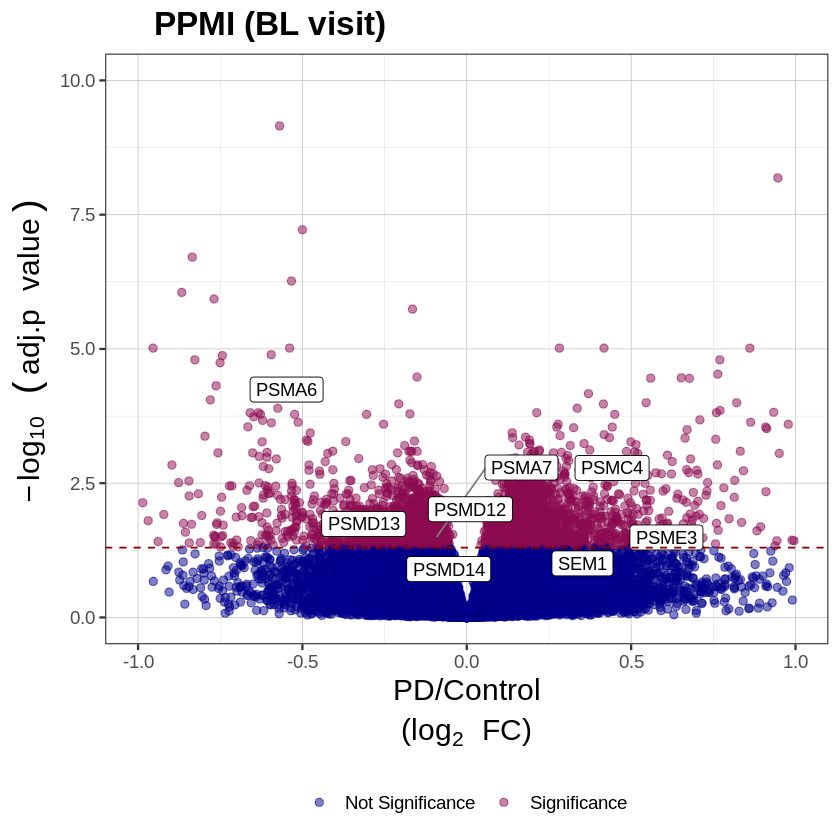

In [ ]:
#VOLCANO PLOT ----
# Enhanced plot with scientific presentation
ggplot(myTopHits2.df, aes(x = logFC, y = -log10(adj.P.Val))) +
  geom_point(aes(color = sig),alpha=1/2,size = 2) +
  scale_color_manual(values = c("not sig" = "darkblue", "sig" = "deeppink4"),
                     labels = c("not sig" = "Not Significance", "sig" = "Significance")) +
  ggrepel::geom_label_repel(data = myTopHits3.df.sig,
                            aes(label = external_gene_name	), box.padding = 0.35,
                            point.padding = 0.5, segment.color = 'grey50') +
  geom_hline(yintercept = 1.3, linetype = "dashed", color = "darkred") +
  #geom_vline(xintercept = c(-0.1, 0.1), linetype = "dashed", color = "darkred") +
  theme_bw(base_size = 14) +
  theme(
    legend.title = element_blank(),
    legend.position = "bottom",
    plot.title = element_text(hjust = 0.1,size = 20, face = "bold"),
    axis.title = element_text(size = 18,face = "bold"),
    panel.grid.major = element_line(size = 0.2, linetype = 'solid', color = "grey"),
    panel.grid.minor = element_line(size = 0.1, linetype = 'solid', color = "lightgrey")
  ) +
  labs(
    title = "PPMI (BL visit)",
    x =  expression(atop("PD/Control", "(log"[2] ~ "FC)")),
    y = expression(-log[10]  ~ (adj.p ~ value)),
    color = "Significance"
  ) +
  xlim(c(-1,1)) + ylim(c(0,10))

In [ ]:
pdf("Volcano_All-BL_Dec07.pdf",width = 7, height = 10)  # Adjust width and height as needed
# Enhanced plot with scientific presentation
ggplot(myTopHits2.df, aes(x = logFC, y = -log10(adj.P.Val))) +
  geom_point(aes(color = sig),alpha=1/2,size = 2) +
  scale_color_manual(values = c("not sig" = "darkblue", "sig" = "deeppink4"),
                     labels = c("not sig" = "Not Significance", "sig" = "Significance")) +
  ggrepel::geom_label_repel(data = myTopHits3.df.sig,
                            aes(label = external_gene_name	), box.padding = 0.35,
                            point.padding = 0.5, segment.color = 'grey50') +
  geom_hline(yintercept = 1.3, linetype = "dashed", color = "darkred") +
  #geom_vline(xintercept = c(-0.1, 0.1), linetype = "dashed", color = "darkred") +
  theme_bw(base_size = 14) +
  theme(
    legend.title = element_blank(),
    legend.position = "bottom",
    plot.title = element_text(hjust = 0.1,size = 20, face = "bold"),
    axis.title = element_text(size = 18,face = "bold"),
    panel.grid.major = element_line(size = 0.2, linetype = 'solid', color = "grey"),
    panel.grid.minor = element_line(size = 0.1, linetype = 'solid', color = "lightgrey")
  ) +
  labs(
    title = "PPMI (BL visit)",
    x =  expression(atop("PD/Control", "(log"[2] ~ "FC)")),
    y = expression(-log[10]  ~ (adj.p ~ value)),
    color = "Significance"
  ) +
  xlim(c(-1,1)) + ylim(c(0,5))
dev.off()



Warning message:
"Removed 61 rows containing missing values or values outside the scale range
(`geom_point()`)."


pdf 
  2

In [ ]:
# Filter for the most significant version of each gene
filtered_data <- myTopHits2.df %>%
  dplyr::filter(external_gene_name %in% c("PSME3", "PSMD14", "PSMD12", "PSMD13", "USP14", "TRIM65", "TRIM25", "HERC5", "RNF31")) %>%
  group_by(external_gene_name) %>%
  slice_min(order_by = adj.P.Val, n = 1) %>%
  ungroup() %>%
  dplyr::select(external_gene_name, logFC, adj.P.Val) %>%
  mutate(y = -log10(adj.P.Val)) # Add calculated y-axis values explicitly

# Plot with annotations
pdf("Volcano_All-BL_Annotation2_Dec07.pdf", width = 7, height = 10)

ggplot(myTopHits2.df, aes(x = logFC, y = -log10(adj.P.Val))) +
  geom_point(aes(color = sig), alpha = 1/2, size = 2) +
  scale_color_manual(values = c("not sig" = "darkblue", "sig" = "deeppink4"),
                     labels = c("not sig" = "Not Significance", "sig" = "Significance")) +
  ggrepel::geom_label_repel(
    data = filtered_data,
    aes(x = logFC, y = y, label = external_gene_name), # Ensure x and y values match the main plot
    box.padding = 0.35,
    point.padding = 1.5,
    segment.color = 'black', # Line color
    segment.size = 5,       # Line thickness
    direction = "both",       # Ensure flexibility in label placement
    max.overlaps = 20
  ) +
  geom_hline(yintercept = 1.3, linetype = "dashed", color = "darkred") +
  theme_bw(base_size = 14) +
  theme(
    legend.title = element_blank(),
    legend.position = "bottom",
    plot.title = element_text(hjust = 0.1, size = 20, face = "bold"),
    axis.title = element_text(size = 18, face = "bold"),
    panel.grid.major = element_line(size = 0.2, linetype = 'solid', color = "grey"),
    panel.grid.minor = element_line(size = 0.1, linetype = 'solid', color = "lightgrey")
  ) +
  labs(
    title = "PPMI (BL visit)",
    x = expression(atop("PD/Control", "(log"[2] ~ "FC)")),
    y = expression(-log[10] ~ (adj.p ~ value)),
    color = "Significance"
  ) +
  xlim(c(-1, 1)) + ylim(c(0, 5))

dev.off()

drive_upload("Volcano_All-BL_Annotation2_Dec07.pdf")


Warning message:
"Removed 61 rows containing missing values or values outside the scale range
(`geom_point()`)."


pdf 
  2

Local file:

• Volcano_All-BL_Annotation2_Dec07.pdf

Uploaded into Drive file:

• Volcano_All-BL_Annotation2_Dec07.pdf <id: 19Zh-2PoyKRIs4VYNrh8rAjHgalk1qBUl>

With MIME type:

• application/pdf



# decideTests


In [ ]:
# Adjust the decideTests parameters
results <- decideTests(ebFit, p.value = 0.05, lfc = 0.1)



In [ ]:
# Clean the gene/transcript IDs in decideTests results
transcript_ids <- rownames(results)  # Assuming rownames are Ensembl transcript IDs
clean_transcript_ids <- gsub("\\..*", "", transcript_ids)  # Remove version numbers

# Retrieve gene symbols for the transcript IDs
gene_info <- getBM(
  filters = "ensembl_transcript_id",
  attributes = c("ensembl_transcript_id", "external_gene_name"),
  values = clean_transcript_ids,
  mart = ensembl
)

# Convert decideTests results into a dataframe for annotation
results_df <- as.data.frame(results) %>%
  rownames_to_column(var = "ensembl_transcript_id")  # Add rownames as a column

# Add cleaned transcript IDs to the results dataframe
results_df <- results_df %>%
  mutate(ensembl_transcript_id = clean_transcript_ids)

# Merge with gene annotation data
annotated_results <- results_df %>%
  left_join(gene_info, by = "ensembl_transcript_id")

# Rearrange columns to have gene symbols as the first column if available
if ("external_gene_name" %in% colnames(annotated_results)) {
  annotated_results <- annotated_results %>%
    dplyr::select(external_gene_name, everything())
}

# Check the annotated results
head(annotated_results)

,external_gene_name,ensembl_transcript_id,PD_vs_Control
,<chr>,<chr>,<dbl>
1,DDX11L16,ENST00000456328,0
2,WASH7P,ENST00000488147,0
3,FAM138A,ENST00000461467,0
4,,ENST00000466430,0
5,,ENST00000471248,0
6,NA,ENST00000610542,0


In [ ]:
writexl::write_xlsx(annotated_results,"decideTest_All_BL_Dec07.xlsx")

In [ ]:
drive_upload("decideTest_All_BL_Dec07.xlsx")

Auto-refreshing stale OAuth token.

Local file:

• decideTest_All_BL_Dec07.xlsx

Uploaded into Drive file:

• decideTest_All_BL_Dec07.xlsx <id: 1bG6wyDTiyatK8EL5ZsEXGE1qUWfiR929>

With MIME type:

• application/vnd.openxmlformats-officedocument.spreadsheetml.sheet



       PD_vs_Control
Down            1613
NotSig         91192
Up              2764

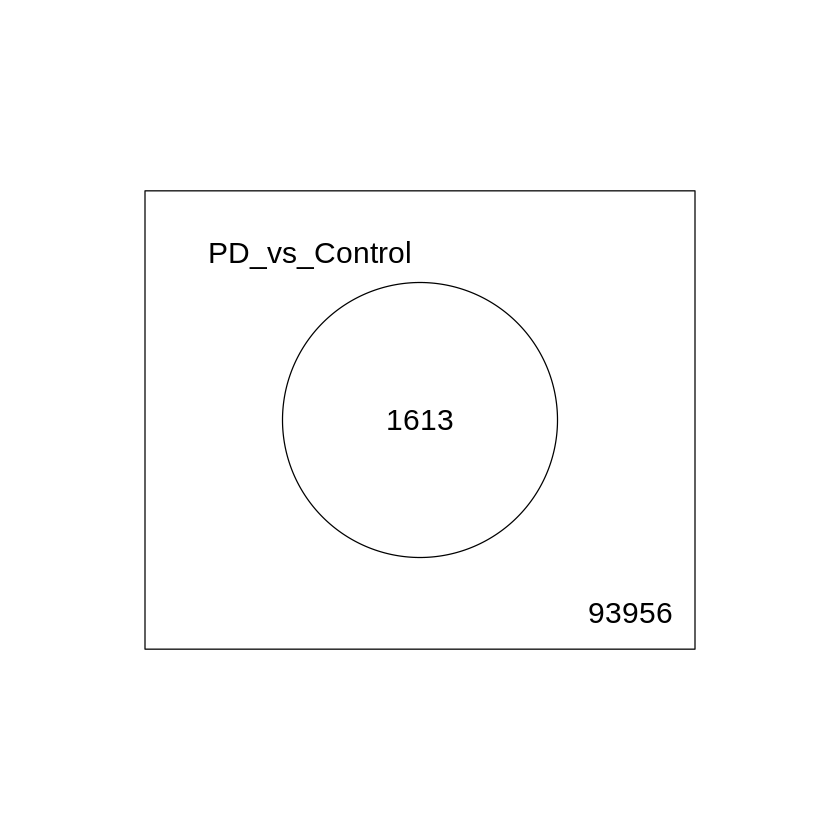

In [ ]:
summary(results)

vennDiagram(results, include="down")


# Specific genes boxplot


In [ ]:
save(NAME.log2.cpm.filtered.norm.df, file = "NAME.log2.cpm.filtered.norm.df.RData")


In [ ]:
drive_upload("NAME.log2.cpm.filtered.norm.df.RData")

Local file:

• NAME.log2.cpm.filtered.norm.df.RData

Uploaded into Drive file:

• NAME.log2.cpm.filtered.norm.df.RData <id: 1RZRKha9m-2aXSK2-LaNLML1jVaWixIEC>

With MIME type:

• application/x-gzip



In [ ]:
NAME.log2.cpm.filtered.norm.df

external_gene_name,geneID,3201,4117,3471,3435,3173,3479,4110,3174,⋯,3807,3809,3854,3863,3867,3868,3904,3102,3418,ensembl_transcript_id
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
DDX11L16,ENST00000456328.2,-1.75536331,-2.72778626,-2.31776929,-0.7053399,-1.71852494,-0.4171748,-1.3796648,-1.7105432,⋯,-0.81716382,-1.285989878,-1.3866720,-0.70694002,-0.473177336,-0.5062164,-0.3974117,-1.966552105,-0.26922992,ENST00000456328
WASH7P,ENST00000488147.1,-1.22636564,-1.40236699,-0.73189890,-1.2013187,-1.04222314,-0.6257597,-0.8969784,-0.7433572,⋯,-0.90462852,-0.861894347,-1.3708850,0.07040206,-1.033748666,-0.8989597,-0.2989409,0.192462385,-0.40358596,ENST00000488147
FAM138A,ENST00000461467.1,2.02724750,2.48148116,2.41195200,1.9682301,1.40271789,0.7656834,2.2129789,1.7014641,⋯,1.42025188,1.844043308,1.8992600,1.69696703,1.580660787,0.7536989,0.3471835,1.504275266,1.12164125,ENST00000461467
,ENST00000466430.5,-0.06661282,-0.35007029,-0.05342682,0.1538780,-0.03217241,-0.4913824,0.1884468,-0.0269818,⋯,-0.12739168,-0.003902386,0.3379028,0.45692494,0.356101989,-0.5391353,-0.6151312,0.090361070,0.38359220,ENST00000466430
,ENST00000471248.1,0.77904482,1.60427748,1.13827649,0.9592382,0.79088834,0.7018447,1.5885237,1.8710509,⋯,0.72465979,0.160560384,1.4434459,1.74842841,0.899796576,1.2869529,0.1757427,0.870843282,0.74178313,ENST00000471248
NA,ENST00000610542.1,-1.54909781,-3.69556088,-1.87797488,-1.2146516,-2.41707876,-3.2403707,-4.6274645,-1.4736522,⋯,-2.28345847,0.097031224,-1.6226160,1.33990659,-0.794667828,-1.9572944,-3.0319882,0.002214629,-1.13289816,ENST00000610542
,ENST00000495576.1,-3.40196515,-4.62746453,-4.62746453,-4.6274645,-2.23286109,-3.1516289,-3.1678850,-4.6274645,⋯,-0.61663631,-0.777003863,-4.6274645,-4.62746453,-4.627464526,-4.6274645,-4.6274645,-0.943905060,-4.62746453,ENST00000495576
CICP27,ENST00000442987.3,-1.69916626,-1.60230235,-1.26590635,-0.7089622,-1.49282001,-2.0576012,-1.4848639,-1.7096166,⋯,-1.57070112,-1.706412595,-1.1702218,-1.59239107,-0.813891756,-1.1955248,-1.8700480,-1.319727667,-1.49857558,ENST00000442987
,ENST00000494149.2,-3.90509197,-3.78939776,-2.81490040,-1.0438286,-2.93120652,-4.6274645,-3.5632876,-2.8354740,⋯,-1.75144111,0.635490708,-1.2370533,3.26149886,1.533294481,-2.6304911,-1.5649861,2.648519457,-0.63657208,ENST00000494149


In [ ]:
View(NAME.log2.cpm.filtered.norm.df[,583:585])

3102,3418,ensembl_transcript_id
<dbl>,<dbl>,<chr>
-1.966552105,-0.26922992,ENST00000456328
0.192462385,-0.40358596,ENST00000488147
1.504275266,1.12164125,ENST00000461467
0.090361070,0.38359220,ENST00000466430
0.870843282,0.74178313,ENST00000471248
0.002214629,-1.13289816,ENST00000610542
-0.943905060,-4.62746453,ENST00000495576
-1.319727667,-1.49857558,ENST00000442987
2.648519457,-0.63657208,ENST00000494149


In [ ]:
NAME.log2.cpm.filtered.norm.df2 <- NAME.log2.cpm.filtered.norm.df %>%
  mutate(across(3:584, as.numeric)) %>%
  dplyr::select(-ensembl_transcript_id) %>%
  pivot_longer(
    cols = 3:584,
    names_to = "samples",
    values_to = "expression"
  )

**văn bản in đậm**

In [ ]:
NAME.log2.cpm.filtered.norm.df2$samples <- as.numeric(NAME.log2.cpm.filtered.norm.df2$samples)
str(NAME.log2.cpm.filtered.norm.df2)

tibble [55,621,158 × 4] (S3: tbl_df/tbl/data.frame)
 $ external_gene_name: chr [1:55621158] "DDX11L16" "DDX11L16" "DDX11L16" "DDX11L16" ...
 $ geneID            : chr [1:55621158] "ENST00000456328.2" "ENST00000456328.2" "ENST00000456328.2" "ENST00000456328.2" ...
 $ samples           : num [1:55621158] 3201 4117 3471 3435 3173 ...
 $ expression        : num [1:55621158] -1.755 -2.728 -2.318 -0.705 -1.719 ...


In [ ]:
NAME.log2.cpm.filtered.norm.df2$DIAGNOSIS <- ifelse(
  NAME.log2.cpm.filtered.norm.df2$samples %in% hc_id,"Control","PD" )

In [ ]:
str(NAME.log2.cpm.filtered.norm.df2)

tibble [55,621,158 × 5] (S3: tbl_df/tbl/data.frame)
 $ external_gene_name: chr [1:55621158] "DDX11L16" "DDX11L16" "DDX11L16" "DDX11L16" ...
 $ geneID            : chr [1:55621158] "ENST00000456328.2" "ENST00000456328.2" "ENST00000456328.2" "ENST00000456328.2" ...
 $ samples           : num [1:55621158] 3201 4117 3471 3435 3173 ...
 $ expression        : num [1:55621158] -1.755 -2.728 -2.318 -0.705 -1.719 ...
 $ DIAGNOSIS         : chr [1:55621158] "Control" "PD" "PD" "PD" ...


In [ ]:
View(dplyr::filter(NAME.log2.cpm.filtered.norm.df2, external_gene_name=="PSMB9",samples == 3201))

external_gene_name,geneID,samples,expression,DIAGNOSIS
<chr>,<chr>,<dbl>,<dbl>,<chr>
PSMB9,ENST00000395330.5,3201,-2.482276,Control
PSMB9,ENST00000414474.5,3201,-2.432264,Control
PSMB9,ENST00000464863.1,3201,2.674240,Control
PSMB9,ENST00000374859.2,3201,6.895747,Control
PSMB9,ENST00000467593.1,3201,2.478018,Control


In [ ]:
save(NAME.log2.cpm.filtered.norm.df2, file = "NAME.log2.cpm.filtered.norm.df2.RData")
drive_upload("NAME.log2.cpm.filtered.norm.df2.RData")

Local file:

• NAME.log2.cpm.filtered.norm.df2.RData

Uploaded into Drive file:

• NAME.log2.cpm.filtered.norm.df2.RData <id: 1oYFw0UX27dbEiwzkctk-aaYx4OtCxfqy>

With MIME type:

• application/x-gzip



In [ ]:
NAME.log2.cpm.filtered.norm.df2

external_gene_name,geneID,samples,expression,DIAGNOSIS
<chr>,<chr>,<dbl>,<dbl>,<chr>
DDX11L16,ENST00000456328.2,3201,-1.7553633,Control
DDX11L16,ENST00000456328.2,4117,-2.7277863,PD
DDX11L16,ENST00000456328.2,3471,-2.3177693,PD
DDX11L16,ENST00000456328.2,3435,-0.7053399,PD
DDX11L16,ENST00000456328.2,3173,-1.7185249,PD
DDX11L16,ENST00000456328.2,3479,-0.4171748,Control
DDX11L16,ENST00000456328.2,4110,-1.3796648,PD
DDX11L16,ENST00000456328.2,3174,-1.7105432,PD
DDX11L16,ENST00000456328.2,3454,-1.4533669,PD


In [ ]:
save.image(file = "Workspace_PPMI_BloodBL_Dec07.RData")

In [ ]:
drive_upload("Workspace_PPMI_BloodBL_Dec07.RData")

Local file:

• Workspace_PPMI_BloodBL_Dec07.RData

Uploaded into Drive file:

• Workspace_PPMI_BloodBL_Dec07.RData <id: 1iEmrsM6iGB5rfuVIxDMdPFe2BkLnsMWO>

With MIME type:

• application/x-gzip

